Suppose

* $K(x,x') = \exp(-\frac{\|x-x'\|^2}{2\ell^2})$ with $\ell=0.5$ (RBF with lengthscale 0.5)
* Independent noises
    * $\epsilon_1\sim N(0, \sigma^2 = 0.09)$
* $f$ is mean zero GP with kernel $K$
* $y_1 = 2 f(x) + \epsilon_1$

Generate 100 observations of $(x, y_1, y_2)$ according to $x \in\{ 0.01, 0.02, 0.03, \cdots 1\}$ using ``sklearn``, then try to recover parameters with ``gpytorch``

In [1]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

import numpy as np
import matplotlib.pyplot as plt

import math
import torch
import gpytorch


In [2]:
l = 0.5
sigma1 = 0.3
n = 100

X = np.linspace(0.01, 1, 100).reshape(-1,1)

K = RBF(length_scale=l)

f = GaussianProcessRegressor(kernel=K)
f_obs = f.sample_y(X, n_samples=1, random_state=1234)
f_obs = f_obs[:,0]

# generate noise

np.random.seed(12345)

y1 = 2 * f_obs + np.random.normal(scale=sigma1, size=100)


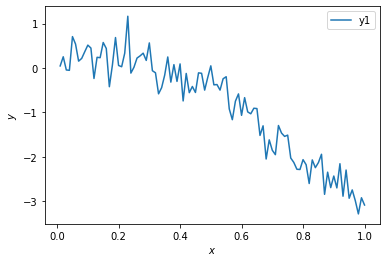

In [3]:
plt.plot(X, y1, label="y1")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

In [4]:
train_x = torch.from_numpy(X).float()
train_y = torch.from_numpy(y1).float()

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


In [8]:
training_iter = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()


Iter 1/200 - Loss: 0.333   lengthscale: 0.605   noise: 0.092
Iter 2/200 - Loss: 0.335   lengthscale: 0.651   noise: 0.102
Iter 3/200 - Loss: 0.333   lengthscale: 0.617   noise: 0.095
Iter 4/200 - Loss: 0.333   lengthscale: 0.588   noise: 0.088
Iter 5/200 - Loss: 0.334   lengthscale: 0.580   noise: 0.086
Iter 6/200 - Loss: 0.334   lengthscale: 0.589   noise: 0.087
Iter 7/200 - Loss: 0.333   lengthscale: 0.605   noise: 0.090
Iter 8/200 - Loss: 0.333   lengthscale: 0.622   noise: 0.093
Iter 9/200 - Loss: 0.333   lengthscale: 0.636   noise: 0.096
Iter 10/200 - Loss: 0.333   lengthscale: 0.641   noise: 0.097
Iter 11/200 - Loss: 0.333   lengthscale: 0.638   noise: 0.097
Iter 12/200 - Loss: 0.333   lengthscale: 0.629   noise: 0.095
Iter 13/200 - Loss: 0.333   lengthscale: 0.619   noise: 0.093
Iter 14/200 - Loss: 0.333   lengthscale: 0.609   noise: 0.091
Iter 15/200 - Loss: 0.333   lengthscale: 0.604   noise: 0.090
Iter 16/200 - Loss: 0.333   lengthscale: 0.604   noise: 0.089
Iter 17/200 - Los

``model.state_dict()`` returns nonsensical values since they're on log scale:

In [9]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-2.3351])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale', tensor(4.4980)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.1500]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

In [13]:
print(np.exp(model.covar_module.base_kernel.raw_lengthscale.item()))
model.covar_module.base_kernel.lengthscale.item()

0.8607186806942286


0.6209627389907837

In [14]:
raw_outputscale = model.covar_module.raw_outputscale
constraint = model.covar_module.raw_outputscale_constraint

In [16]:
constraint.transform(model.covar_module.base_kernel.raw_lengthscale)

tensor([[0.6210]], grad_fn=<SoftplusBackward0>)

In [ ]:
model.covar_module.task_covar_module.covar_matrix.evaluate()

Still not sure what this is

In [ ]:
print(model.covar_module.task_covar_module.raw_var)
print(torch.exp(model.covar_module.task_covar_module.raw_var))

The lengthscale **should** be 0.5

In [ ]:
print(model.covar_module.data_covar_module.raw_lengthscale)
print(torch.exp(model.covar_module.data_covar_module.raw_lengthscale))